# 使用Tikit完成图像分类模型构建
本案例集通过一个简单的图像分类场景，演示如何使用平台开发套件Tikit在Notebook中提交训练任务，注册模型，同时演示如何使用平台功能将模型部署上线，并进行在线测试功能演示。
通过此案例的学习，您可以完成平台端到端模型开发、纳管和上线流程。

## 案例集使用说明

1. TI平台Notebook的案例集空间的笔记本均为只读模式，若您需要进行编辑和运行，请先点击右上方【Create a Copy】将案例集拷贝至个人工作空间下；
2. 本案例集所使用的代码和数据集均保存在拷贝后的文件目录下，其中/code下为训练脚本和启动脚本；/data下为原始训练图像数据。

## 第一步 上传数据集
大部分情况下，我们的训练数据集均会存储在腾讯云数据产品中，例如对象存储COS，文件系统CFS，大数据系统EMR，因此我们提交训练任务的时候需要能够直接访问存储在云上存储产品的数据，本案例先将本地训练数据上传到COS进行演示。
### 1.1 上传数据集到COS

In [ ]:
from tikit.client import Client

# 初始化client。在公有云TI平台的环境（包括notebook和训练任务）中可以不填地区，环境变量中已经有地区信息。
# secret_id获取地址：https://console.cloud.tencent.com/cam/capi。
client = Client("your_secret_id", "your_secret_key", "<region>")

# 上传数据集（注：重复上传不会覆盖，会生成新的子目录，如有需要，可使用 client.delete_cos_path 删除旧数据）
client.upload_to_cos("./data", "demo-1256580188", "notebook-demo-classification/data")

## 第二步 准备训练代码
### 2.1 脚本命名
1. 将算法脚本命名为main.py。
2. 准备本地运行启动命令start_local.sh。
3. 准备提交到远程算力集群启动命令start_cloud.sh。

### 2.2 启用TIACC加速
#### 2.2.1 启用命令
```
启动脚本指定TIACC参数：
--tiacc：是否使用TIACC加速能力，取值范围0/1，，默认为0

ex：sh start_cloud.sh --tiacc=1
```

#### 2.2.2 TIACC使用说明
##### 1 使用TIACC DDP分布式训练通信优化，将torch.distributed.launch替换为tiacc_training.distributed.launch，其他参数保持不变
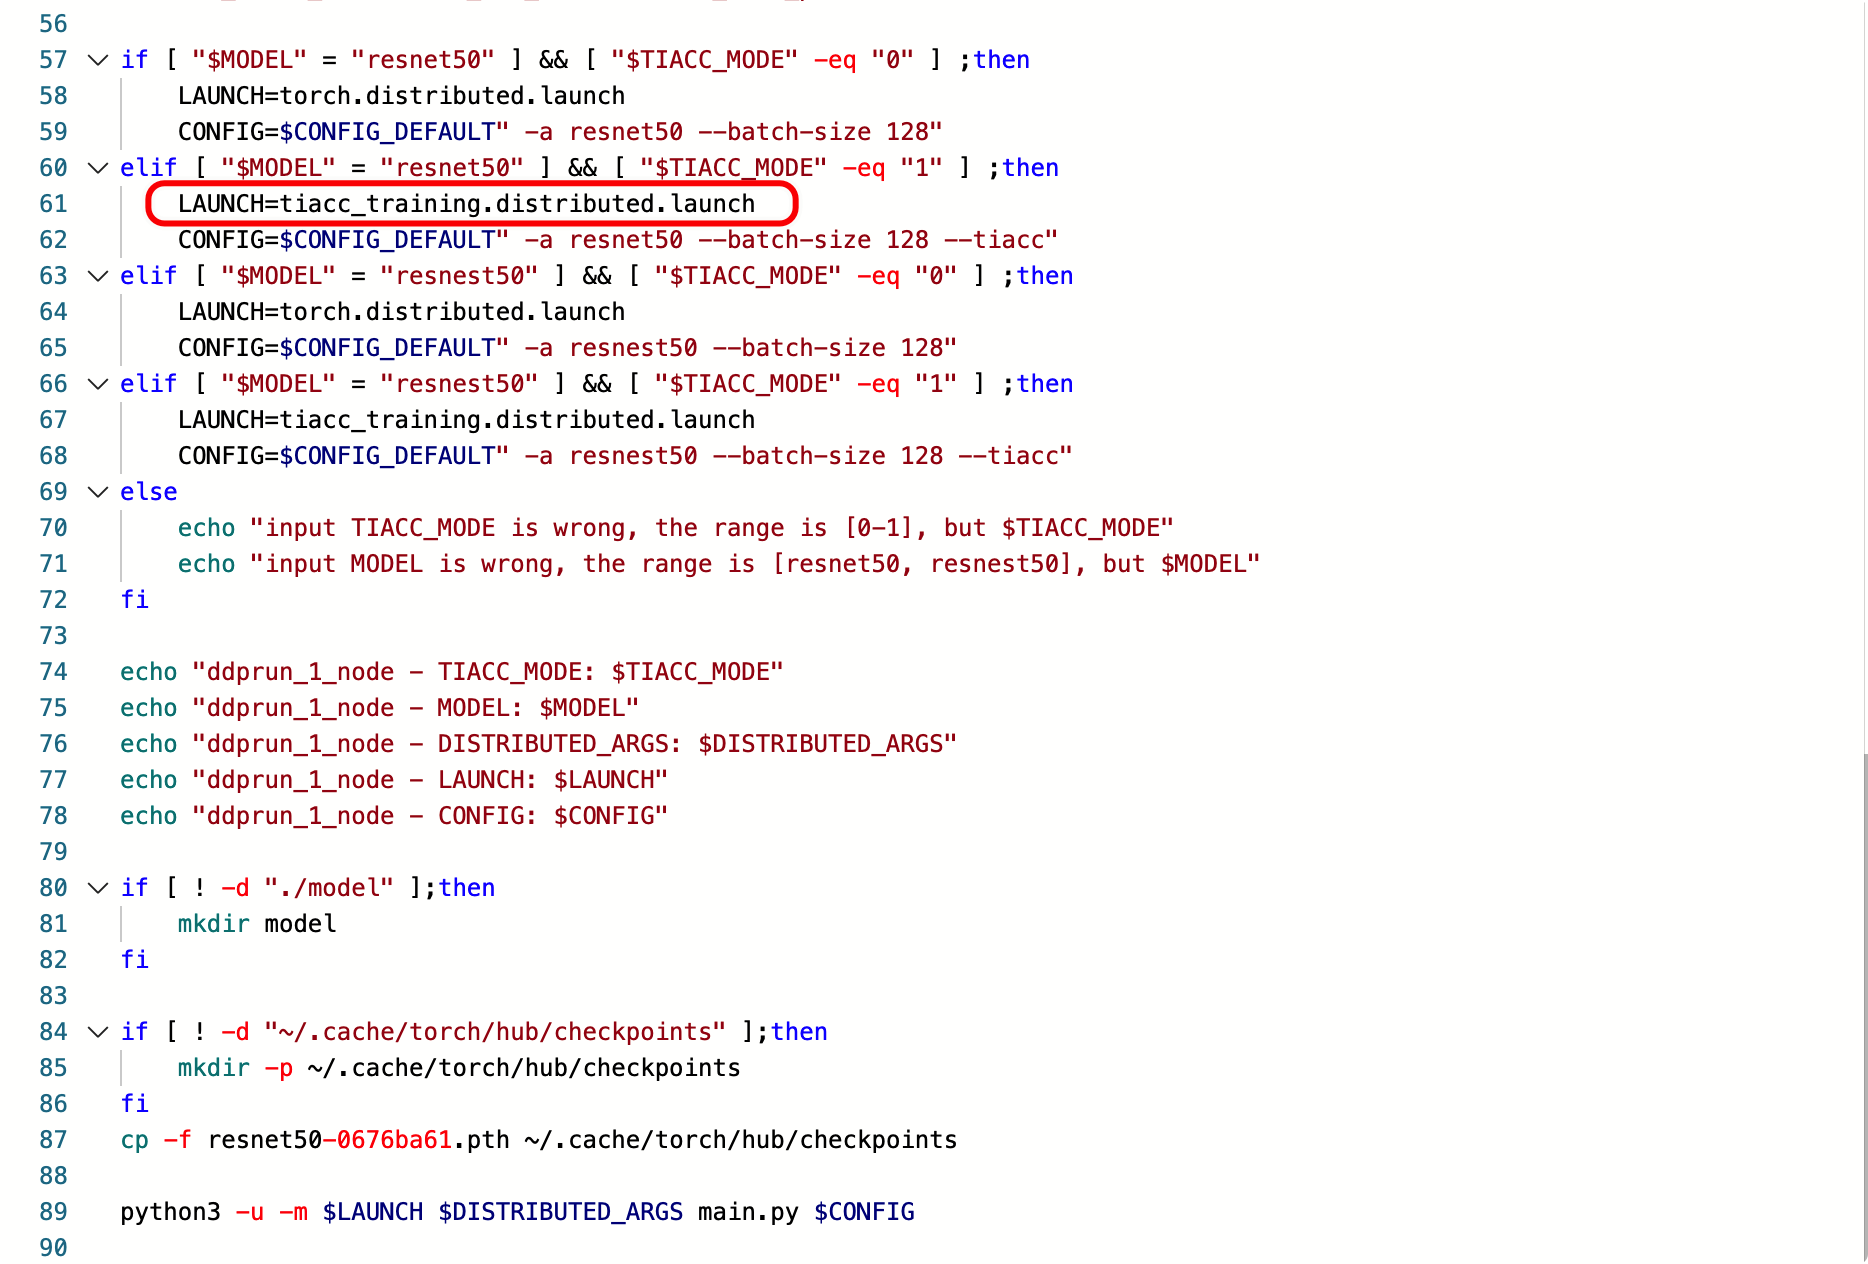
##### 2 使用TIACC优化器
##### 2.1 导入tiacc_training
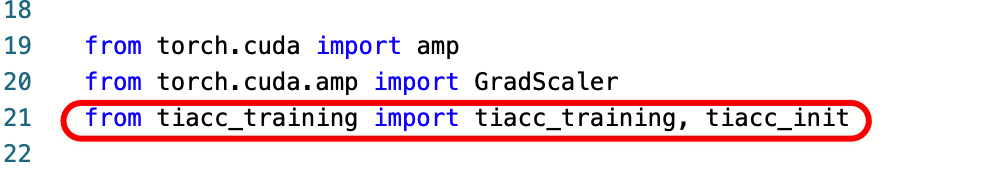
##### 2.2 在main()函数外添加tiacc_init修饰器
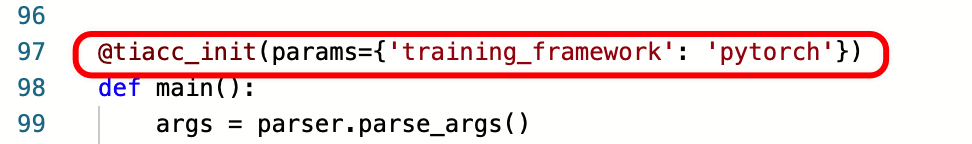
##### 2.3 使用tiacc fused optimizer，输入为torch标准优化器；get_fused_optimizer：用于封装pytorch原生的optimizer以获取更快的optimizer更新速度
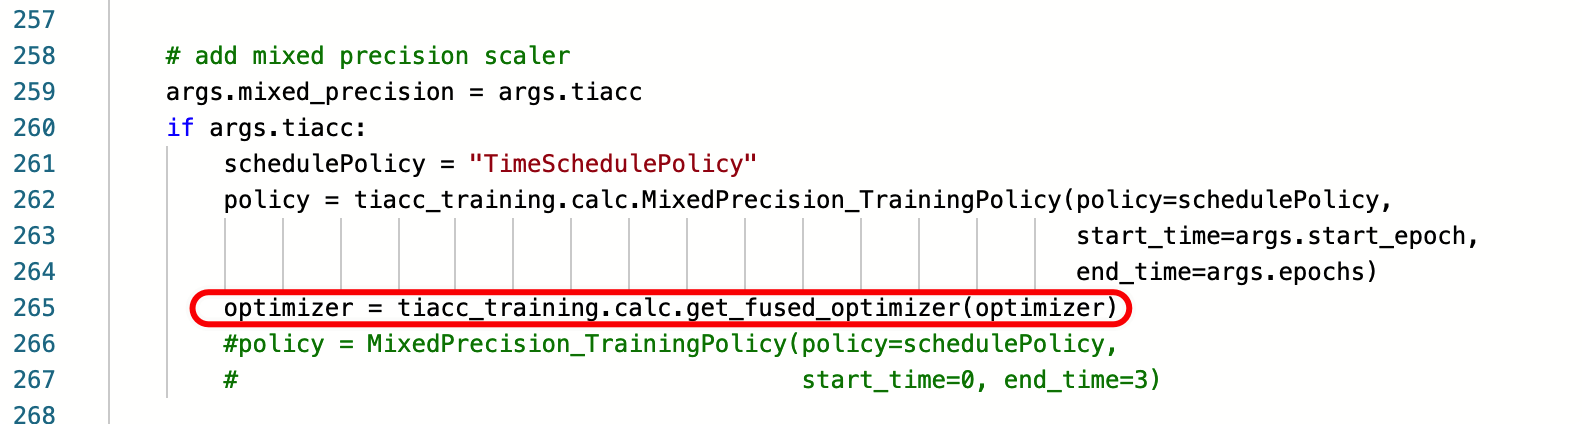
##### 3 使用自适应混合精度优化
##### 3.1 实例化tiacc自适应混合精度策略类的对象；MixedPrecision_TrainingPolicy：实现对训练过程中自动混合精度自适应策略的实例化，自适应策略包括时间混合精度、时间学习率混合精度策略、损失函数混合精度策略。
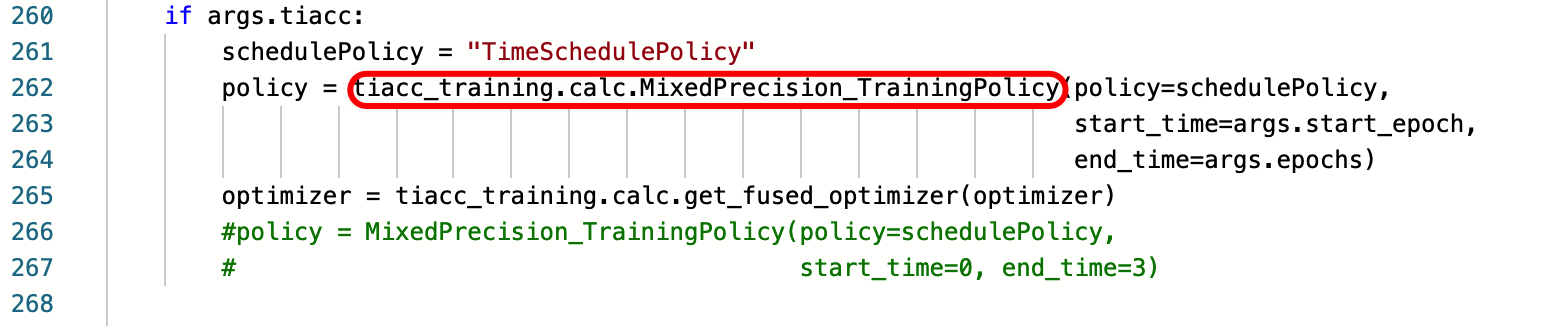
##### 3.2 根据输入的参数得到当前epoch是否需要开启混合精度；MixedPrecision_TrainingPolicy.enable_mixed_precision：属于MixedPrecision_TrainingPolicy类，根据输入的参数得到当前epoch是否需要开启自动混合精度。
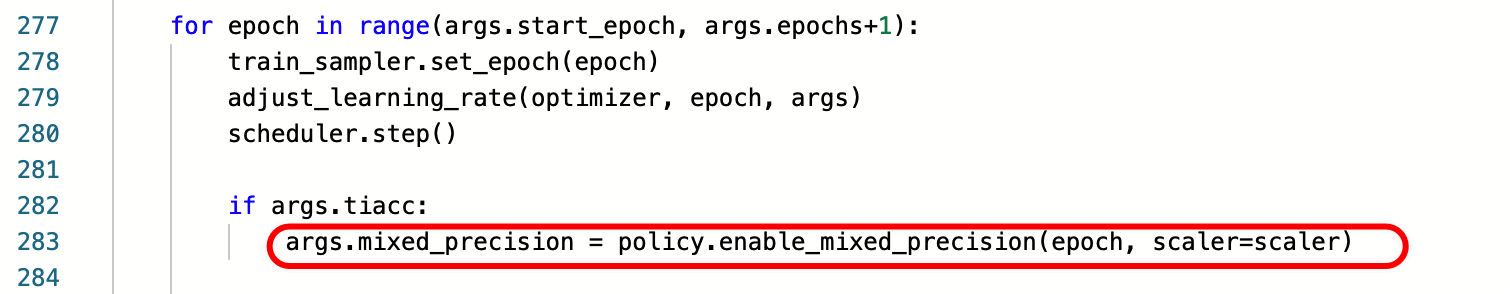
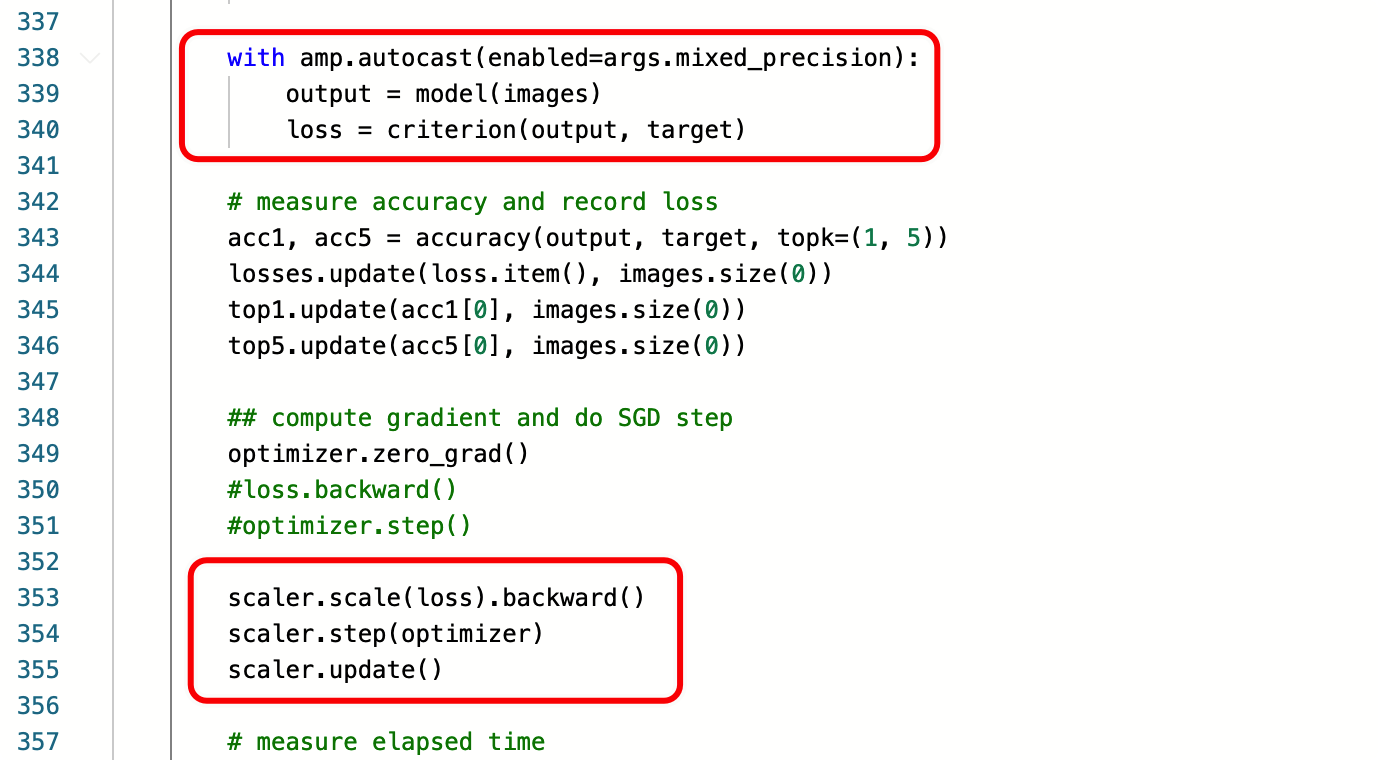

### 2.3 根据Pytorch 1.9提供的接口开发训练算法
```
使用pytorch ddp进行分布式多机训练时，启动命令有 --nodes，--node_rank，--nproc_per_node，--master_addr，–master_port等几个参数（详见pytorch官方文档）：

--nnodes：对应环境变量NODE_NUM
--node_rank：对应环境变量INDEX
--nproc_per_node：对应环境变量GPU_NUM_PER_NODE
--master_addr：对应环境变量CHIEF_IP
--master_port：没有对应环境变量，用户自己指定一个即可

```

### 2.4 读取训练数据
在启动命令main.py后紧跟训练数据路径，/opt/ml/input/data是平台任务默认的数据存放路径（这个路径存在于训练机器上），在任务启动后，会将cos中的数据下载到这个指定的路径下或自定义子路径下（例如这里的image_classify），用户脚本读取对应路径下的数据即可。
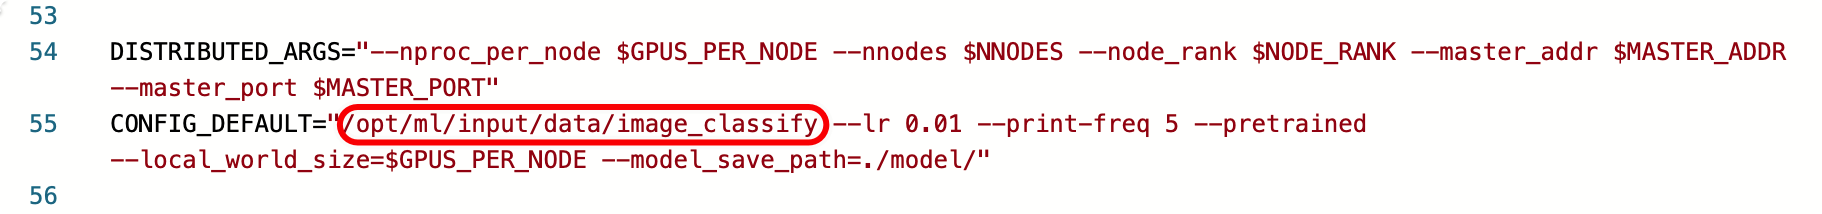

### 2.5 自定义上传指标
#### 2.5.1 初始化tikit（这里需要替换为用户自己的secret_id、secret_key）
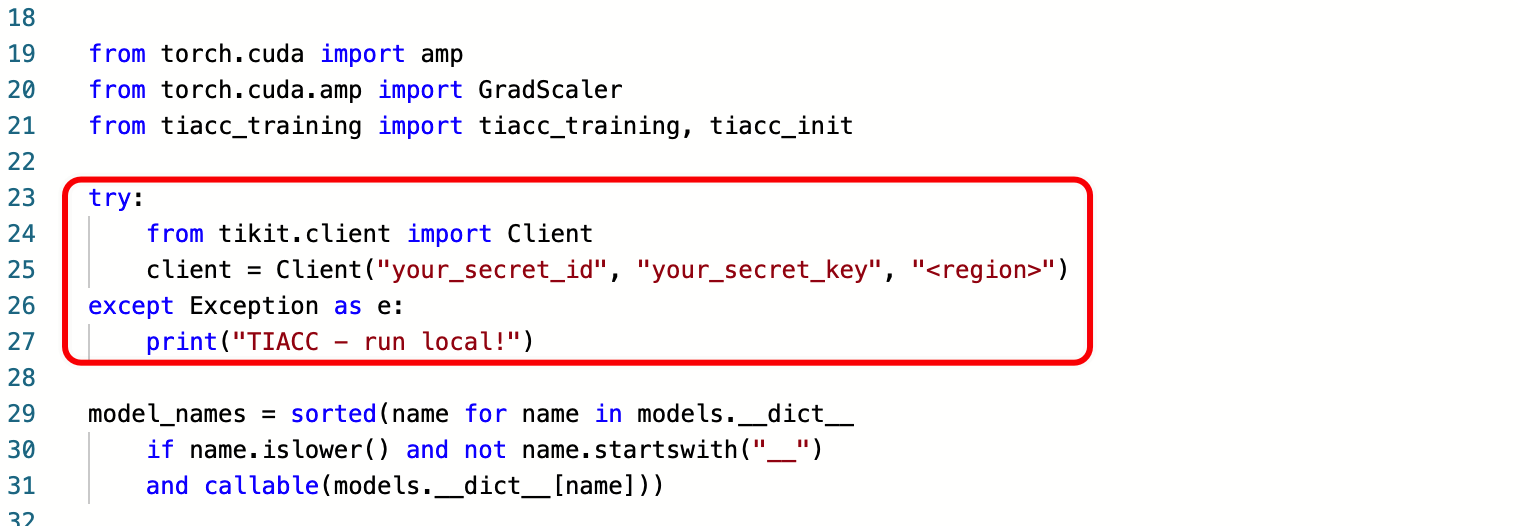
#### 2.5.2 查看上传指标用法

In [2]:
# 查看上传指标方法
help(client.push_training_metrics)

Help on method push_training_metrics in module tikit.client:

push_training_metrics(timestamp, value_map, task_id=None, epoch=None, total_steps=None, step=None) method of tikit.client.Client instance
    上报训练自定义指标（单条）。单个子账号每秒可以调用20次，请在您的训练代码中注意控制上报频率，避免超限报错。或者使用push_training_metrics_list
    
    :param timestamp:   时间戳
    :type timestamp:    int
    :param value_map:   指标映射。 指标名称 -> 指标值
    :type value_map:    map: str -> float
    :param task_id:     任务ID。若为空，就当前取任务节点环境的 TI_TASK_ID 环境变量的值
    :type task_id:      str
    :param epoch:       epoch值
    :type epoch:        int
    :param total_steps: 总步数
    :type total_steps:  int
    :param step:        第几步
    :type step:         int
    :return:
    :rtype:             :class:`tikit.tencentcloud.tione.v20211111.models.PushTrainingMetricsResponse`
    
    client.push_training_metrics(int(time.time()), {"field1": 11, "field2": 12}, "task-id-00001", 3, 1000, 66)



#### 2.5.2 上传指标
在valide函数中，上传训练指标acc1和acc5。
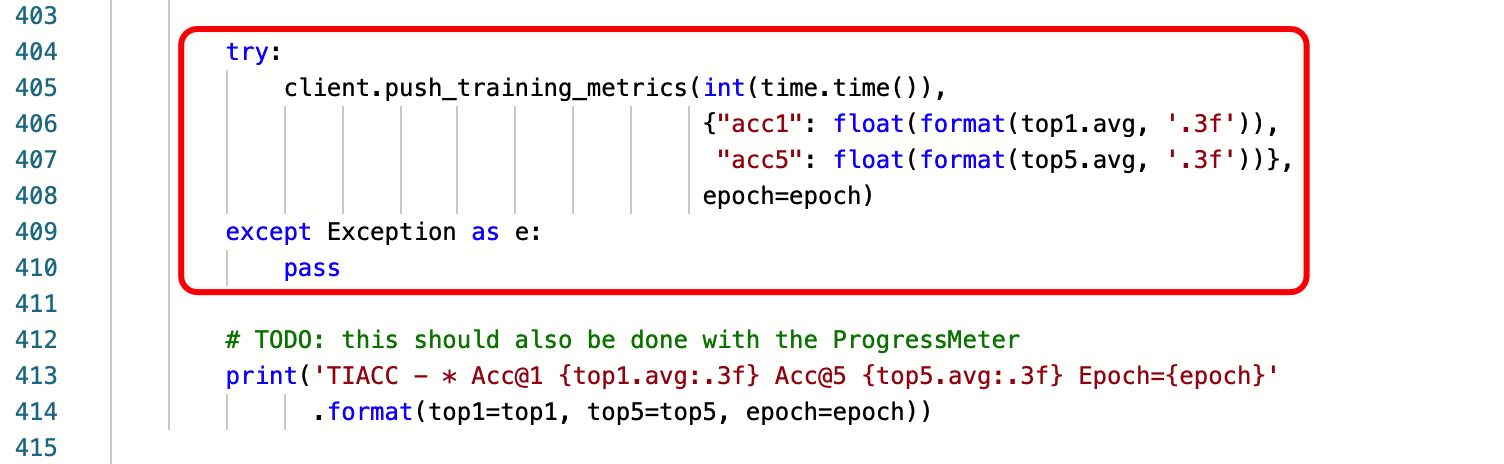

任务完成后，可以在“任务式建模/监控”下查看指标（可能会存在一点延迟）。
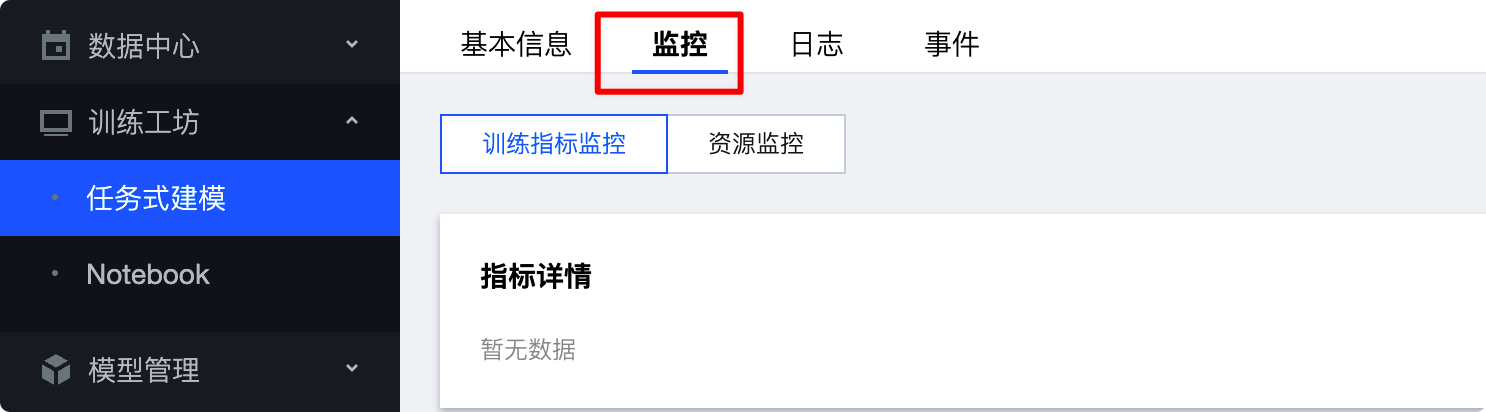

### 2.6 上传训练代码到COS
此时，我们已经准备好训练代码了，将写好的训练代码上传到cos中，后续提交训练任务时读取cos中的代码。

In [3]:
client.upload_to_cos("./code", "demo-1256580188", "notebook-demo-classification/code")

## 第三步 本地调试
start_local.sh是可以本地运行脚本，脚本中已经指定了训练数据路径，用户可以切换到tiacc_pytorch_py3环境（source activate tiacc_pytorch_py3）直接执行sh start_local.sh命令运行（注：该脚本需要GPU环境，如果当前notebook不是GPU环境，则需要启动一个GPU环境的notebook运行）。
运行命令：

```
cd ~/classify_example_2022-04-28/code
source activate tiacc_pytorch_py3
sh start_local.sh
```

## 第四步 使用Tikit提交训练任务

In [3]:
# 查询计算资源配置
client.describe_postpaid_training_price()

配置名称,描述,每小时价格（单位：元）
TI.S.MEDIUM.POST,2C4G,0.46
TI.S.LARGE.POST,4C8G,0.9
TI.S.2XLARGE16.POST,8C16G,1.13
TI.S.2XLARGE32.POST,8C32G,1.44
TI.S.4XLARGE32.POST,16C32G,2.22
TI.S.4XLARGE64.POST,16C64G,2.85
TI.S.6XLARGE48.POST,24C48G,5.34
TI.S.6XLARGE96.POST,24C96G,3.97
TI.S.8XLARGE64.POST,32C64G,3.53
TI.S.8XLARGE128.POST,32C128G,5.29


In [2]:
#创建训练任务
from tikit import models

framework = models.FrameworkInfo.new_system_framework("PYTORCH", "ti-acc2.0-torch1.9-py3.8-cuda11.1-gpu", "DDP")
worker_resource = models.ResourceConfigInfo.new_postpaid("TI.GN10.2XLARGE40.POST", 2)

# 'demo-1256580188/notebook-demo-classification/data'是第一步数据上传的cos路径，
# '/opt/ml/input/data/image_classify'是步骤2.3中指定的数据读取路径
input_data = models.TrainingDataConfig.new_cos_data({"demo-1256580188/notebook-demo-classification/data/":"/opt/ml/input/data/image_classify"})

client.create_training_task("demo-classification", 
                            framework, 
                            "demo-1256580188/output/", 
                            worker_resource, 
                            input_data_config=input_data, 
                            code_package_path="demo-1256580188/notebook-demo-classification/code/",
                            worker_start_cmd="sh start_cloud.sh")

{"Id": "train-23725882022301696", "RequestId": "6fe64c51-693e-4f2e-8818-0fb2e85c648f"}

## 第五步 注册模型

In [4]:
# 查看推理镜像。（运行查看最新版本信息）
client.describe_system_reasoning_images()

算法框架,算法框架版本号,支持的训练框架集合,镜像标识,镜像url
TENSORFLOW,2.4,"['TENSORFLOW', 'LIGHT']",tensorflow2.4-py38(cpu),ccr.ccs.tencentyun.com/qcloud-ti-platform/ti-cloud-infer-tensorflow-cpu:py38-tf2.4-cpu-1.0.0
TENSORFLOW,2.4,"['TENSORFLOW', 'LIGHT']",tensorflow2.4-py38(gpu),ccr.ccs.tencentyun.com/qcloud-ti-platform/ti-cloud-infer-tensorflow-gpu:py38-tf2.4-cu11.0-tiacc2.0.0-1.0.1
TENSORFLOW,2.4,"['TENSORFLOW', 'LIGHT']",tfserving2.4(cpu),ccr.ccs.tencentyun.com/qcloud-ti-platform/tensorflow-serving:2.4.0
TENSORFLOW,2.4,"['TENSORFLOW', 'LIGHT']",tfserving2.4(gpu),ccr.ccs.tencentyun.com/qcloud-ti-platform/tensorflow-serving:2.4.0-gpu
TENSORFLOW,1.15,"['TENSORFLOW', 'LIGHT', 'TI_ACC']",tensorflow1.15-py37(cpu),ccr.ccs.tencentyun.com/qcloud-ti-platform/ti-cloud-infer-tensorflow-cpu:py37-tf1.15-cpu-1.0.0
TENSORFLOW,1.15,"['TENSORFLOW', 'LIGHT', 'TI_ACC']",tensorflow1.15-py37(gpu),ccr.ccs.tencentyun.com/qcloud-ti-platform/ti-cloud-infer-tensorflow-gpu:py37-tf1.15-cu10.0-1.0.0
TENSORFLOW,1.15,"['TENSORFLOW', 'LIGHT', 'TI_ACC']",tfserving1.15(cpu),ccr.ccs.tencentyun.com/qcloud-ti-platform/tensorflow-serving:1.15.0
TENSORFLOW,1.15,"['TENSORFLOW', 'LIGHT', 'TI_ACC']",tfserving1.15(gpu),ccr.ccs.tencentyun.com/qcloud-ti-platform/tensorflow-serving:1.15.0-gpu
PYTORCH,1.9,"['PYTORCH', 'LIGHT', 'TI_ACC', 'AUTOML_CV']",pytorch1.9.0-py38(cpu),ccr.ccs.tencentyun.com/qcloud-ti-platform/ti-cloud-infer-pytorch-cpu:py38-torch1.9.0-cpu-1.0.0
PYTORCH,1.9,"['PYTORCH', 'LIGHT', 'TI_ACC', 'AUTOML_CV']",pytorch1.9.0-py38(gpu),ccr.ccs.tencentyun.com/qcloud-ti-platform/ti-cloud-infer-pytorch-gpu:py38-torch1.9.0-cu111-tiacc2.0.0-1.0.2


In [6]:
# 创建训练模型
reasoning_env = models.ReasoningEnvironment.new_system_environment("pytorch1.9.0-py38(gpu)")
# 模型输出路径
module_output_path = models.CosPathInfo("demo-1256580188", "output/train-23725882022301696/", "ap-guangzhou")
# 这里训练任务ID就是上面创建的训练任务ID
client.create_model_by_task("demo-classification-model", "train-23725882022301696", reasoning_env, module_output_path, "PYTORCH")

{"Id": "m-542040440611504896", "TrainingModelVersionId": "mv-v1-542040440611504897", "RequestId": "c9db5faf-8801-49b3-b13d-a7e6c3be4ad8"}

## 第六步 模型发布
模型发布需要准备的模型包需包含 model_service.py 推理脚本和 config.json、mapping.json 配置文件，以及对应的模型权重文件夹 /model 和 模型结构脚本 net.py。

### 6.1 下载推理模板（本案例推理脚本存放于infer_code）
推理模型在模型仓库页面进行下载，如下图所示：
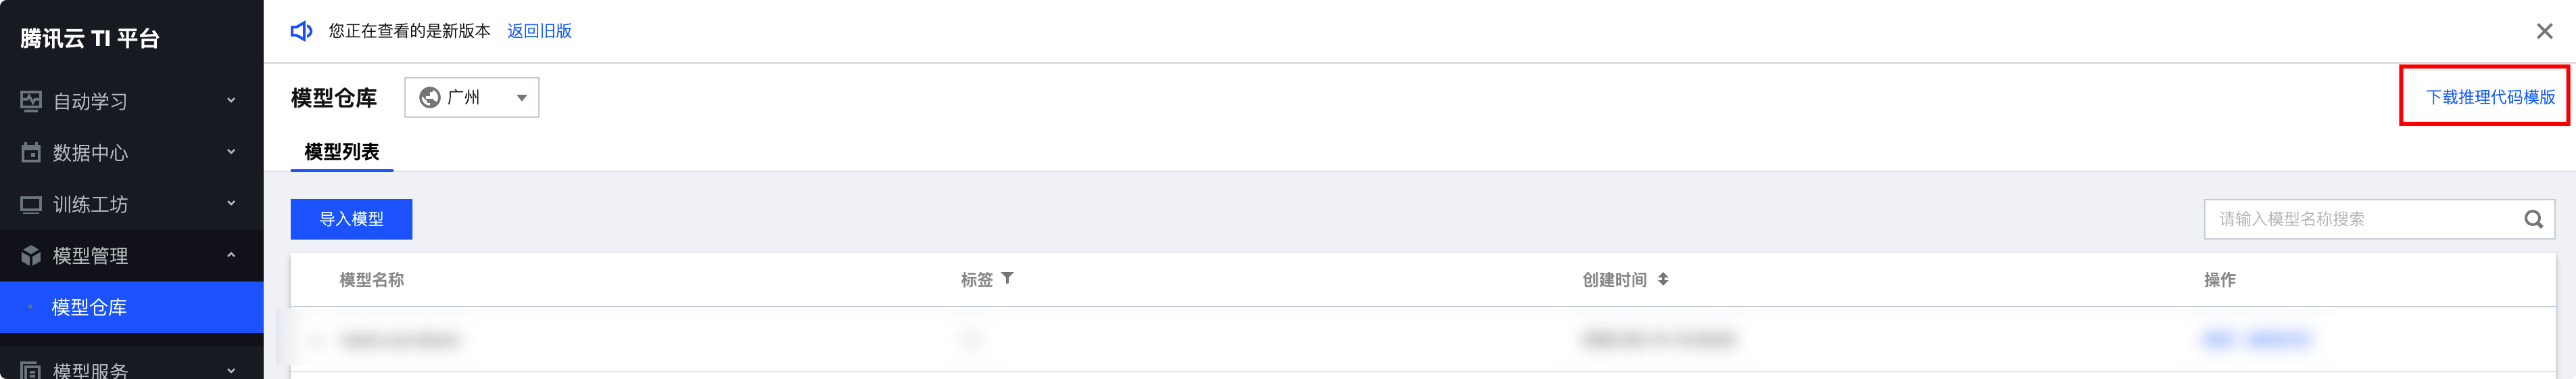
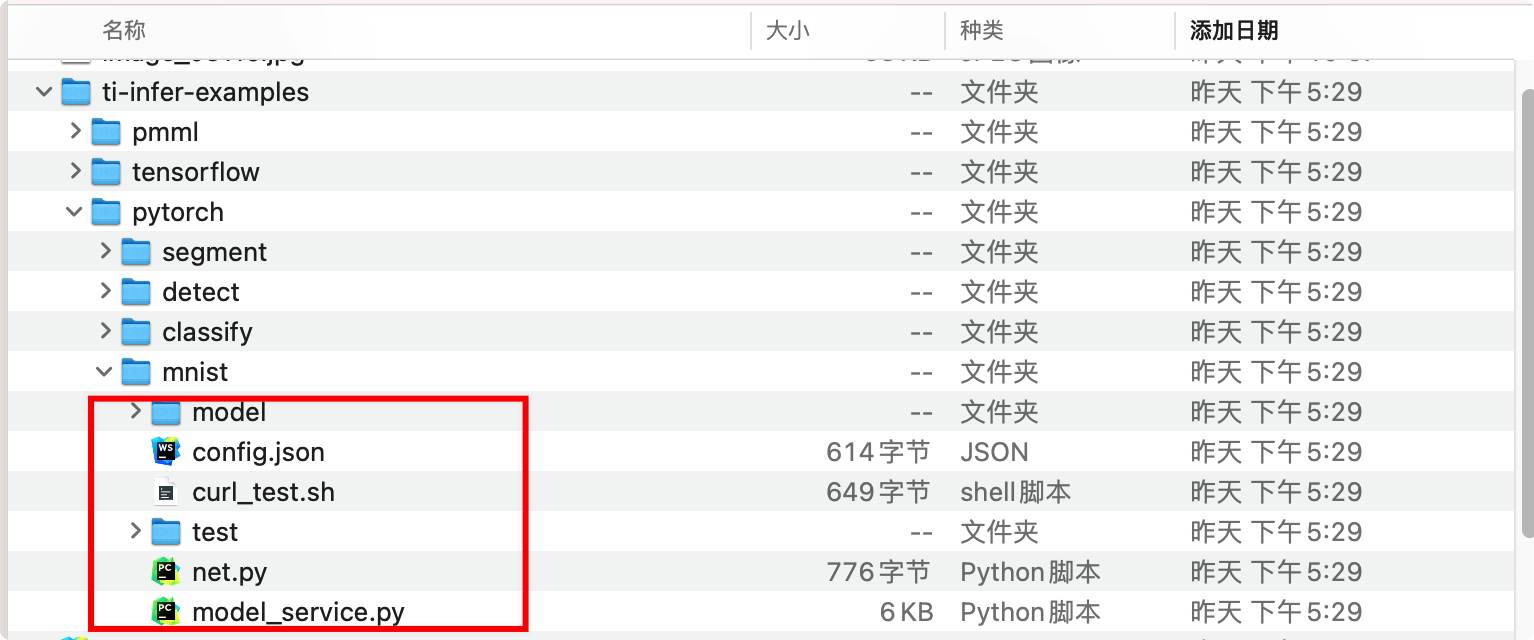

### 6.2 本地调试推理脚本

#### 6.2.1 切换环境
```
cd ~/classify_example_2022-04-28/infer_code
source activate pytorch_py3
```

#### 6.2.2 启动命令  

1.--model_dir 将会拼接您脚本目录下的model目录。 

2.启动命令默认会执行当前路径下model_service.py脚本。

```
python3 -m tiinfer --http_port 8501 --algorithm_name m --model_dir ./
```

#### 6.2.3 脚本测试    

使用示例中的curl_test.sh请求测试脚本。
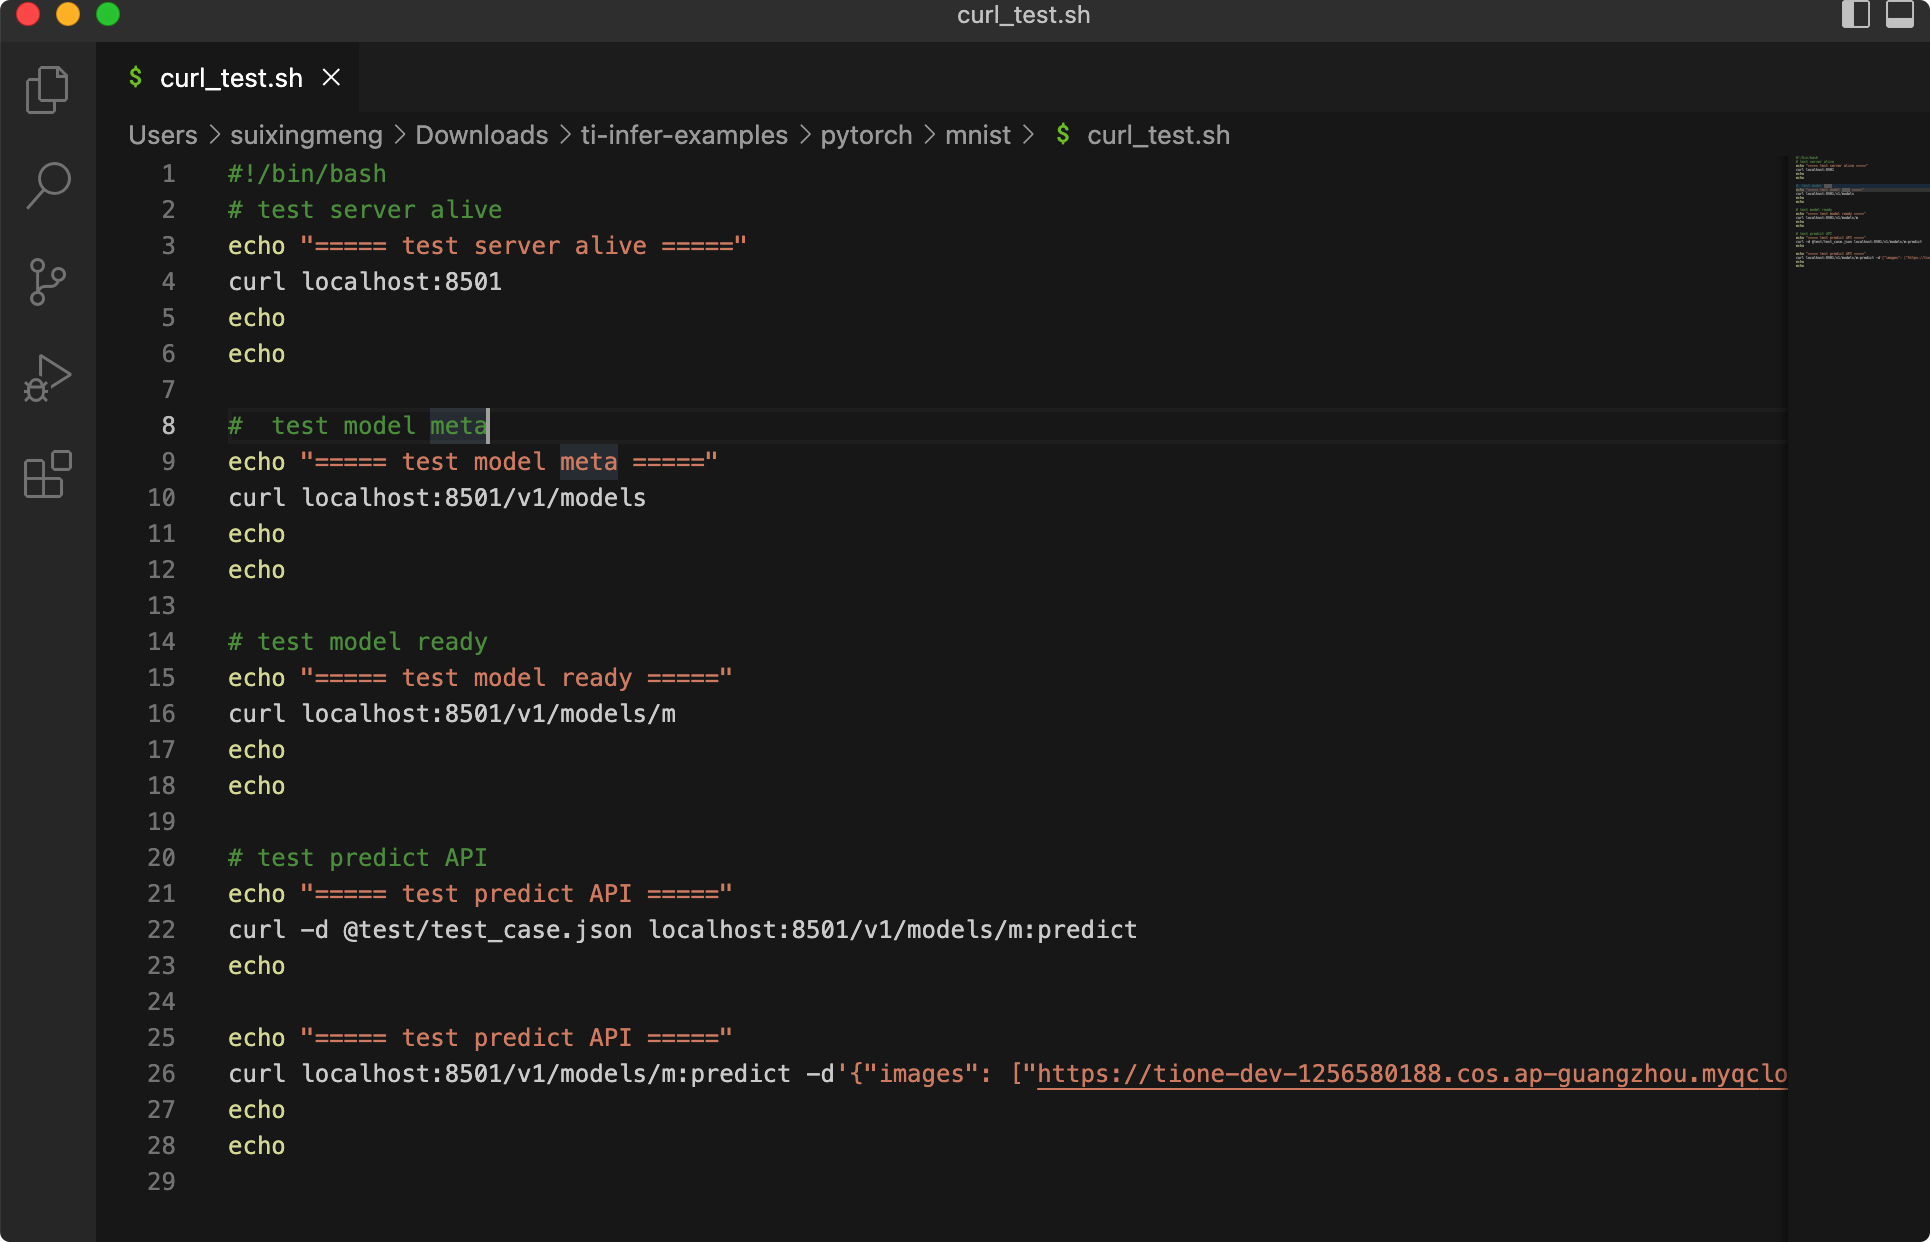

#### 6.2.4 推理脚本model_service.py讲解 

PYTORCH_FILE 变量指定具体模型文件，会和启动命令中的--model_dir路径拼接。
推理过程为：
1. preprocess（image预处理）
2. predict（调用模型进行预测）
3. postprocess（对算法结果做后处理，返回可读数据格式）

### 6.3 上传推理脚本
在控制台页面上传model_service.py 推理脚本和 config.json、mapping.json 配置文件，和模型结构脚本 net.py。
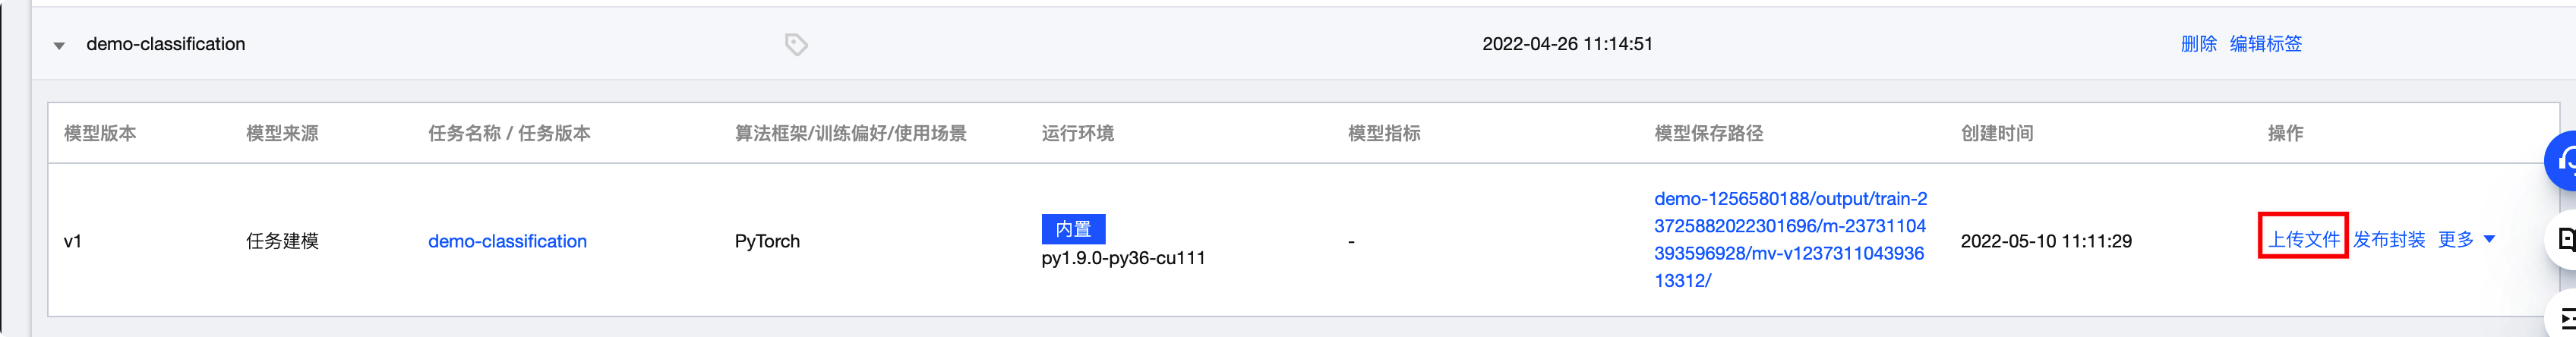
上传完成后显示
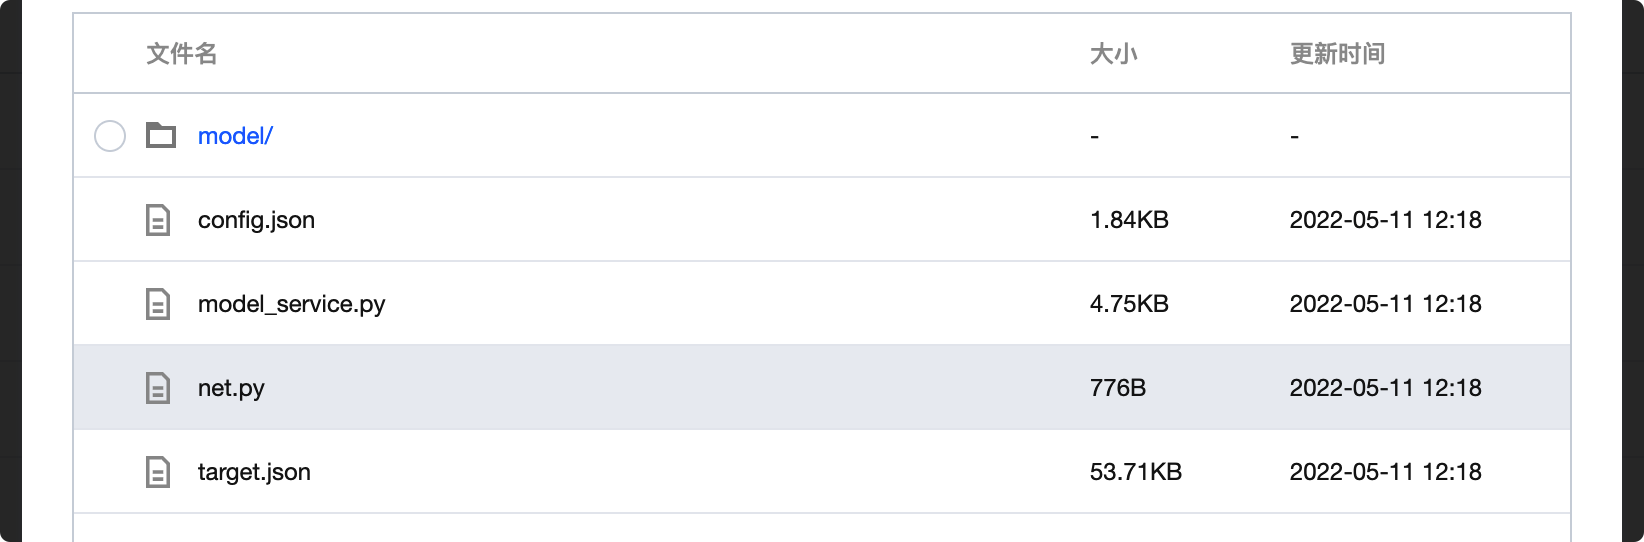

### 6.4 发布封装
在模型仓库页面，点击【发布封装】，进行服务配置，将模型发布为在线服务。
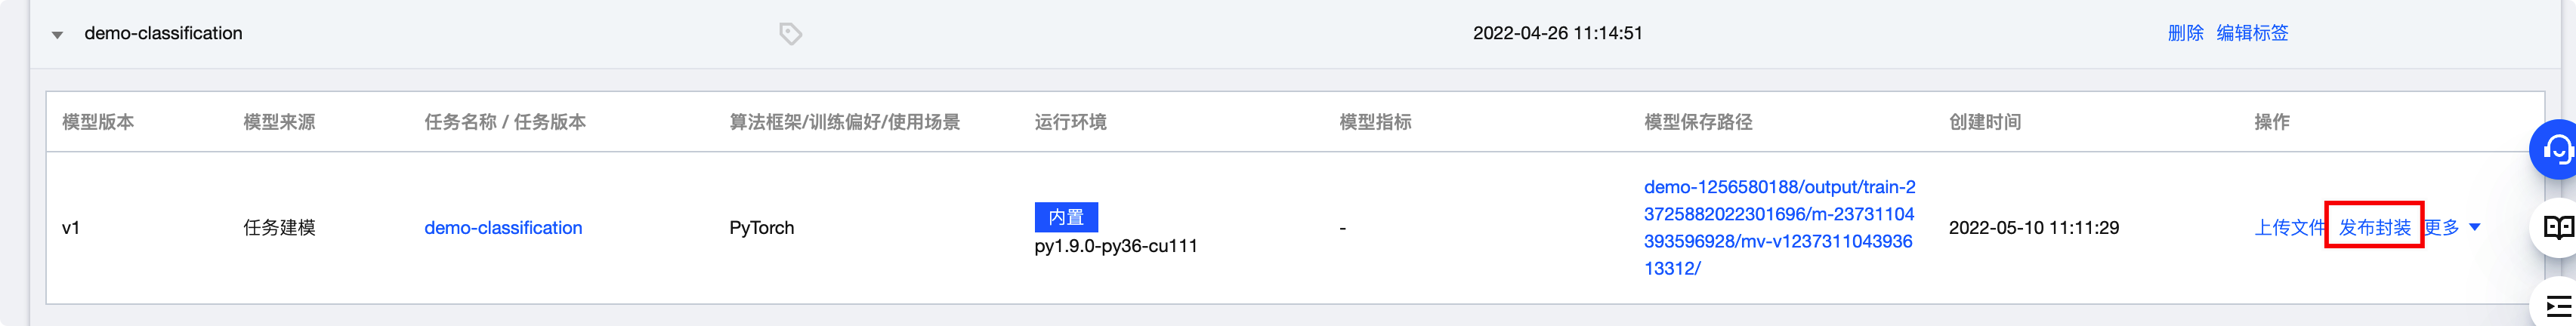
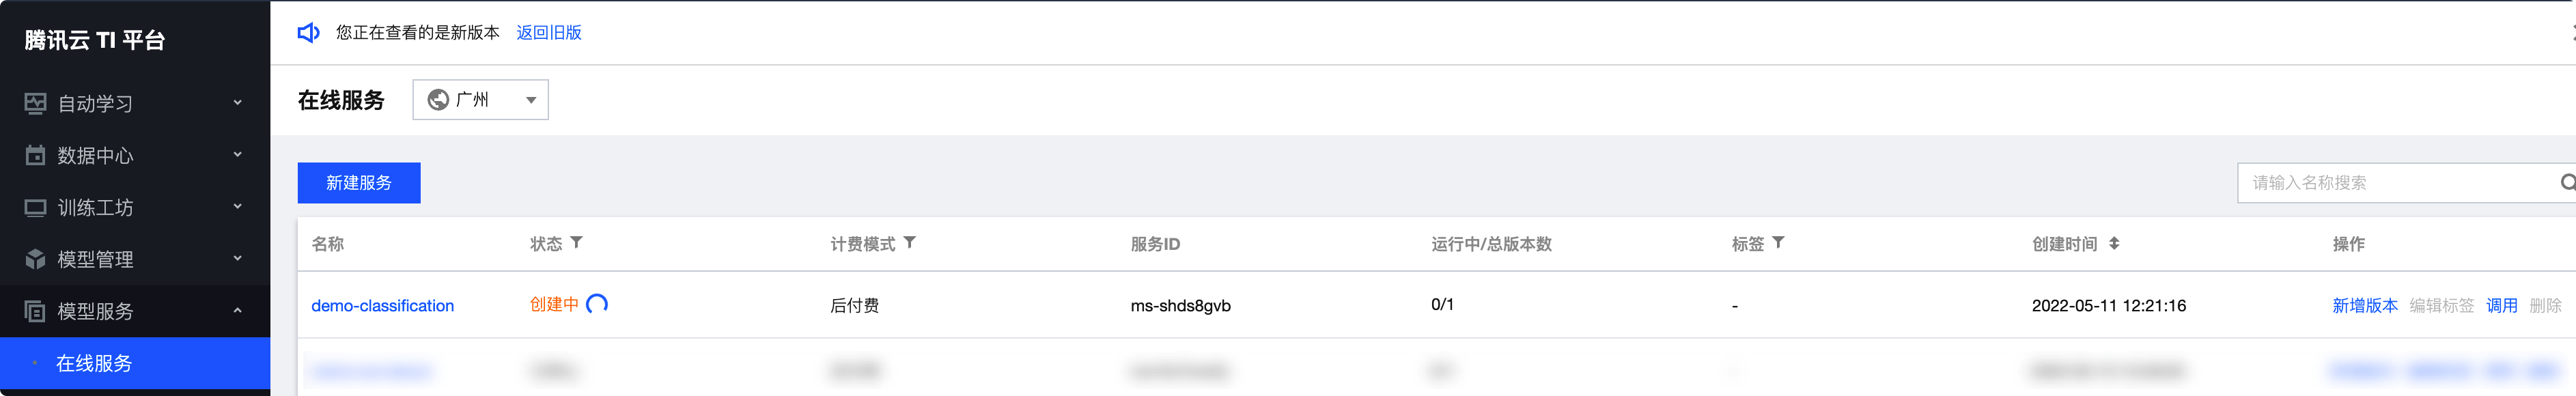

### 6.5 在线调用
服务启动成功后，点击服务名称，进入【服务调用】页面。
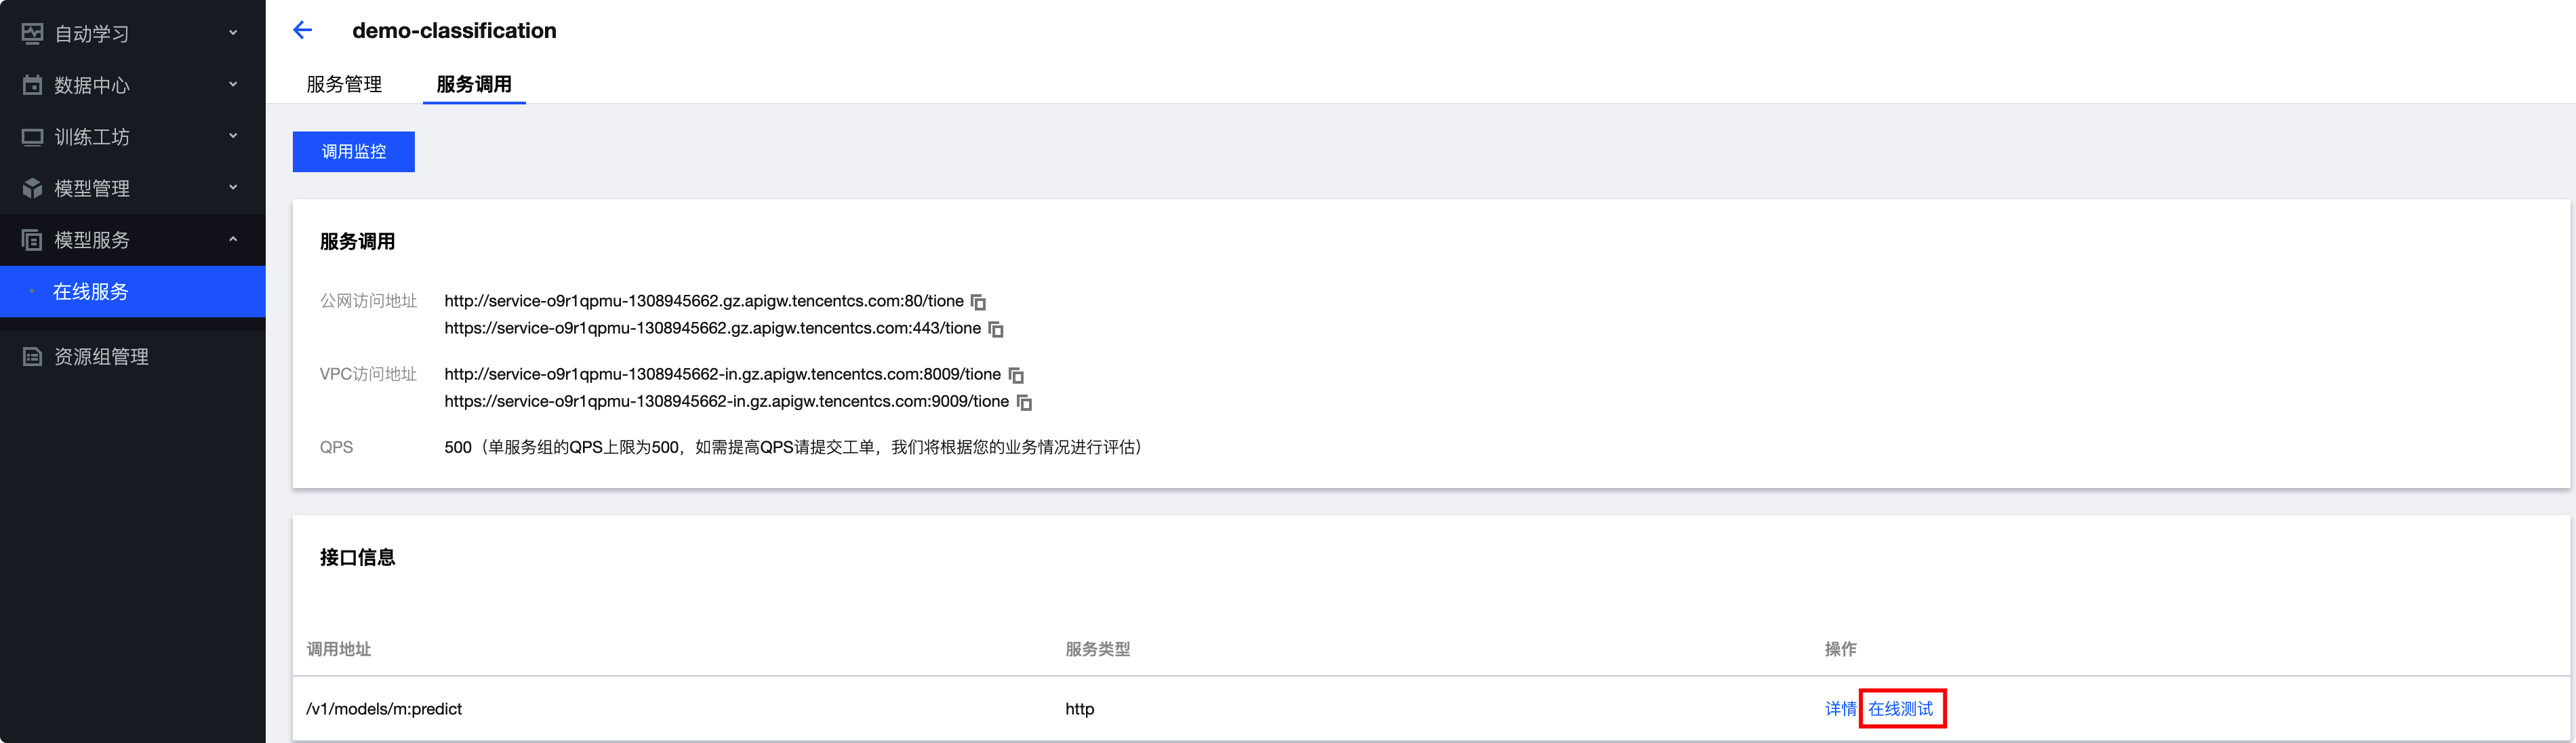
在接口信息操作栏，点击【在线服务】，可以直接在页面上发送请求测试接口调用。
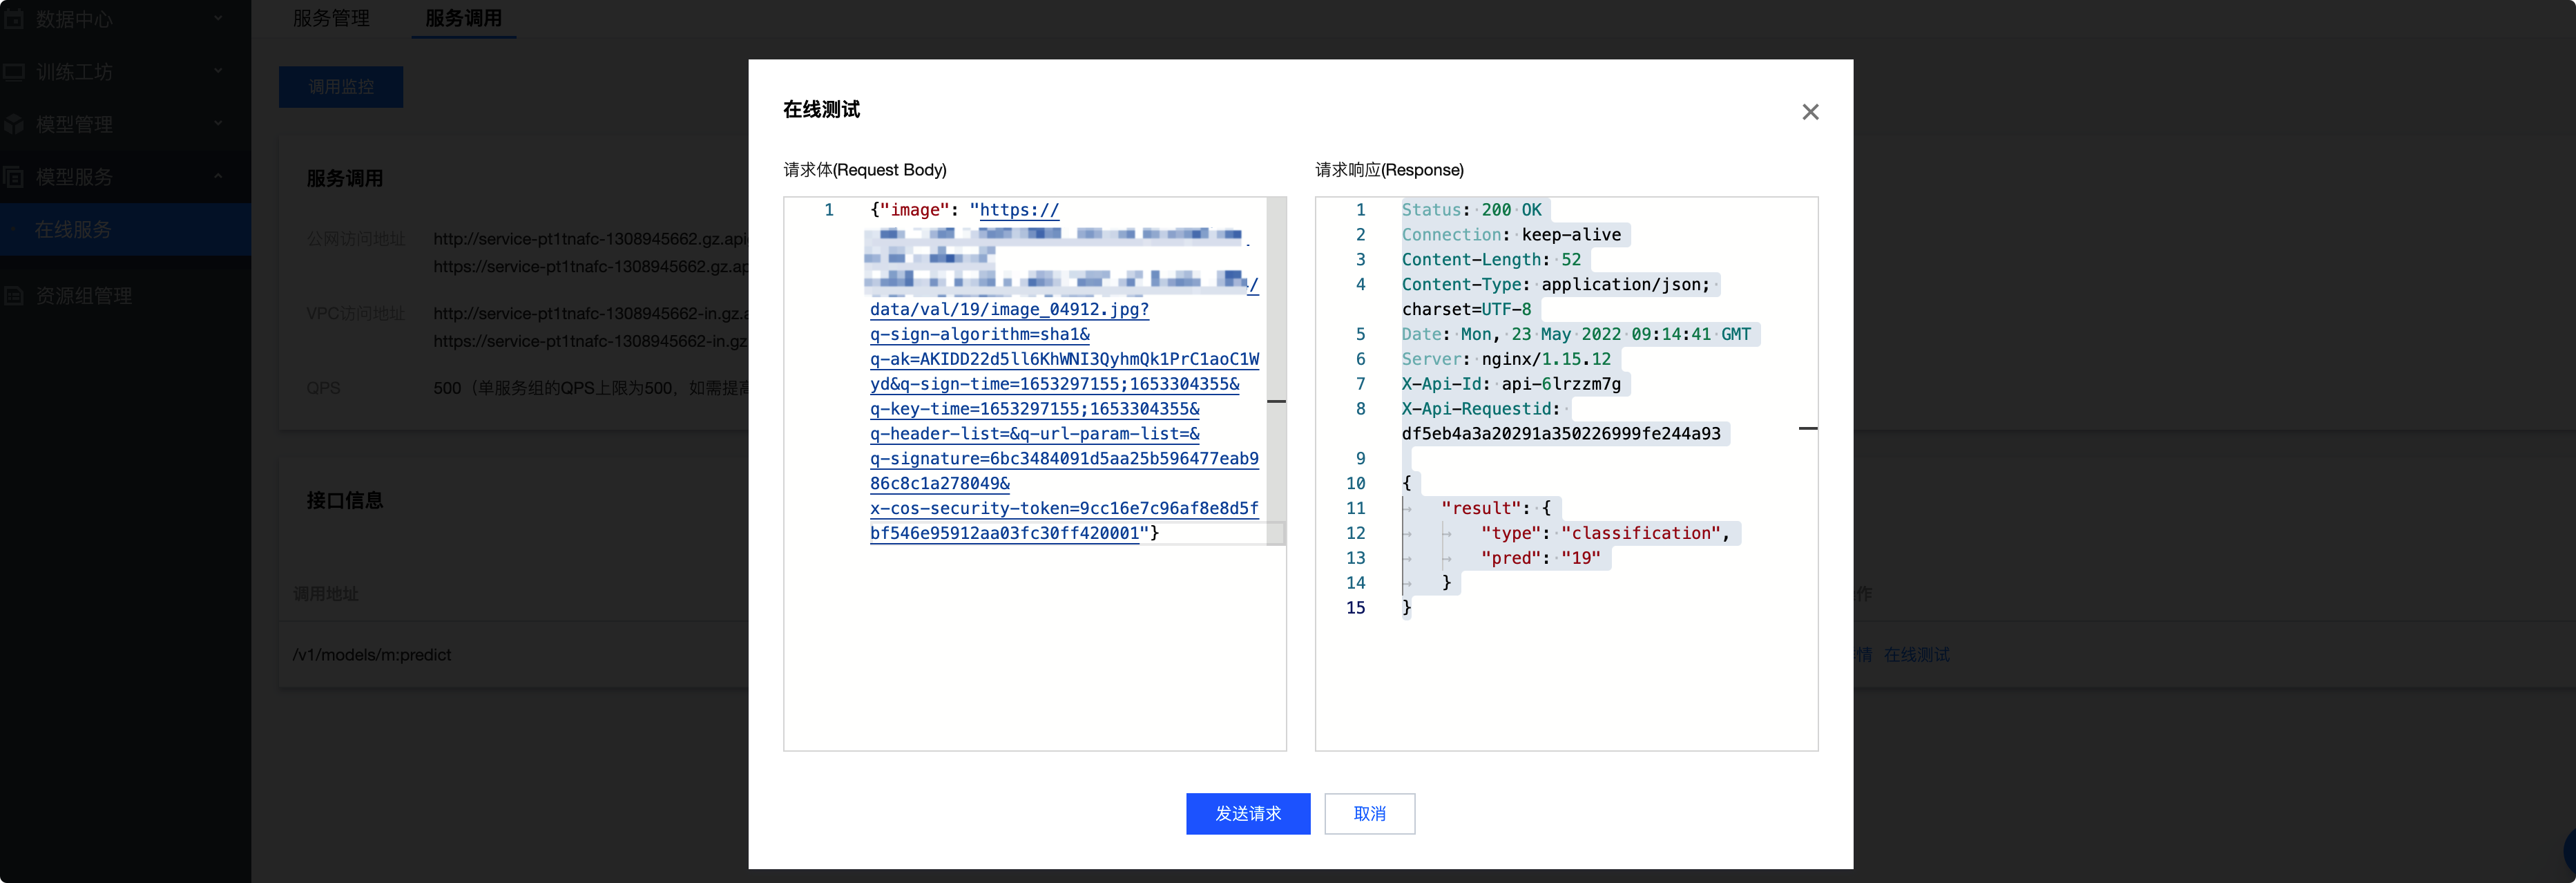